This notebook is saves the plots used in the report regarding comparisons between buoy and model data.
It is heavily inspired by the notebook model_bouy_comparison_analysis.ipynb

# Imports and functions

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import xarray as xr
import os
import pickle
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from pykml.factory import KML_ElementMaker as KML
import lxml
from sklearn.metrics import mean_squared_error
from importlib import reload
import utilities.plots_metrics as pm
reload(pm)

<module 'utilities.plots_metrics' from '/home/sarssw/filip/sarssw/model_bouy_comparison/../utilities/plots_metrics.py'>

In [2]:
def overlappling_hist(data_source_1, data_source_1_label, data_source_2, data_source_2_label, title, x_label, legend_title="Data source", bins = 100, alpha=0.6, y_label='Count'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.hist(data_source_1, bins=bins, alpha=alpha, label=data_source_1_label, color=plt.get_cmap('cividis')(0))
    ax.hist(data_source_2, bins=bins, alpha=alpha, label=data_source_2_label, color='orange')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(title=legend_title)

In [3]:
def scatterplot_and_heatmaps(df, name_text, unit, alpha=0.01, bouy_variable_column='bouy_variable_value', model_varialbe_column='model_value'):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    axs[0].scatter(df[bouy_variable_column], df[model_varialbe_column], alpha=alpha)
    axs[0].plot([0, 1], [0, 1], color='black', transform=axs[0].transAxes, label='Identity line x=y') #Plot identity line
    axs[0].set_title('Scatterplot for ' + name_text)
    axs[0].set_xlabel(f"bouy measurement [{unit}] ({bouy_variable_column})")
    axs[0].set_ylabel(f"model measurement [{unit}] ({model_varialbe_column})")
    axs[0].legend()

    (h2d_h, h2d_xedg, h2d_yedg, h2d_img) = axs[1].hist2d(df[bouy_variable_column], df[model_varialbe_column], bins=100, norm=mpl.colors.LogNorm(clip=True))
    axs[1].plot([0, 1], [0, 1], color='black', transform=axs[1].transAxes, label='Identity line x=y') #Plot identity line
    axs[1].set_title('Heatmap for ' + name_text + ', log scaled colormap')
    axs[1].set_xlabel(f"bouy measurement [{unit}] ({bouy_variable_column})")
    axs[1].set_ylabel(f"model measurement [{unit}] ({model_varialbe_column})")
    fig.colorbar(h2d_img, ax=axs[1], label='Count colormap')
    axs[1].legend()

    hist = h2d_h.copy().T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist *= 1 / hist.sum(axis=0, keepdims=True)
        
    #Remove nans, to remove white columns
    hist[np.isnan(hist)] = 0

    pcm = axs[2].pcolormesh(h2d_xedg, h2d_yedg, hist, norm=mpl.colors.LogNorm(clip=True))
    axs[2].plot([0, 1], [0, 1], color='black', transform=axs[2].transAxes, label='Identity line x=y') #Plot identity line
    axs[2].set_title('Heatmap for ' + name_text + ', normalized columns, log scaled colormap')
    axs[2].set_xlabel(f"bouy measurement [{unit}] ({bouy_variable_column})")
    axs[2].set_ylabel(f"model measurement [{unit}] ({model_varialbe_column})")
    fig.colorbar(pcm, ax=axs[2], label='Frequency colormap')
    axs[2].legend()

    display(fig)
    plt.close()

# Load data

In [4]:
# Load dataframe for features and labels
feature_labels_path = '/data/exjobb/sarssw/sar_dataset_features_labels_22_may/sar_dataset.pickle'
feature_labels = pd.read_pickle(feature_labels_path)

#Filter all nan values
feature_labels_nan = feature_labels[feature_labels.isna().any(axis=1)]
feature_labels = feature_labels[~feature_labels.isna().any(axis=1)]

#Filter only training data
feature_labels = feature_labels[feature_labels['split'] == 'train']

display(feature_labels.columns)
display(feature_labels)

Index(['sar_name', 'bouy_name', 'file_name', 'pol', 'incidence', 'safe',
       'swath', 'platform', 'orbit_pass', 'product', 'platform_heading',
       'polarisations', 'longitude', 'latitude', 'time', 'subimage_index',
       'hom_test', 'contrast', 'dissimilarity', 'homogeneity', 'energy',
       'correlation', 'ASM', 'sigma_mean', 'sigma_var', 'sigma_mean_over_var',
       'sigma_min', 'sigma_max', 'sigma_range', 'acw', 'acw_db', 'acw_median',
       'acw_median_db', 'SWH_value', 'SWH_source', 'SWH_lon', 'SWH_lat',
       'SWH_time', 'WSPD_value', 'WSPD_source', 'WSPD_lon', 'WSPD_lat',
       'WSPD_time', 'split'],
      dtype='object')

,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_source,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split
0,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
1,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
2,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
3,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
4,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704821,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878388,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.299194,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878389,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.298813,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878390,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.273640,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878391,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.247898,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train


In [5]:
#Load models
swh_model_path = '/data/exjobb/sarssw/model/2021_swh_era5_world_wide.nc'
wspd_model_path = '/data/exjobb/sarssw/model/WIND_GLO_PHY_global/all.nc'

print("Loading wave height model")
SWH_model = xr.open_dataset(swh_model_path)

#Wind speed model
print("Loading wind speed model")
WSPD_model = xr.open_dataset(wspd_model_path)

Loading wave height model
Loading wind speed model


# Compare wave height from buoy and model

In [6]:
def long_360_adjust(x):
    if x < 0:
        return x + 360
    return x

In [7]:
bouy_swh_feature_labels = feature_labels[feature_labels['SWH_source'] == 'bouy']
bouy_swh_feature_labels

,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_source,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split
0,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
1,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
2,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
3,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
4,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704821,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,bouy,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878388,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.299194,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878389,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.298813,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878390,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.273640,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train
878391,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.247898,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


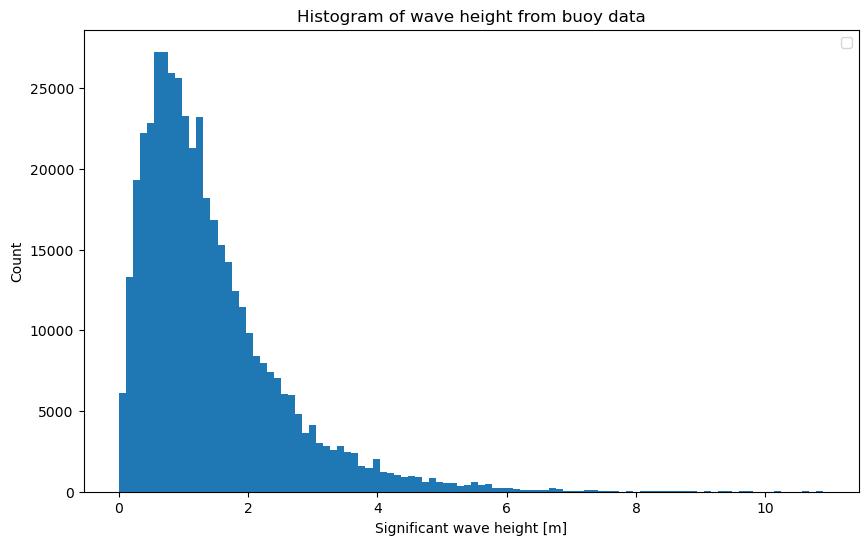

In [8]:
pm.my_histogram(bouy_swh_feature_labels['SWH_value'], "Histogram of wave height from buoy data", "Significant wave height [m]")

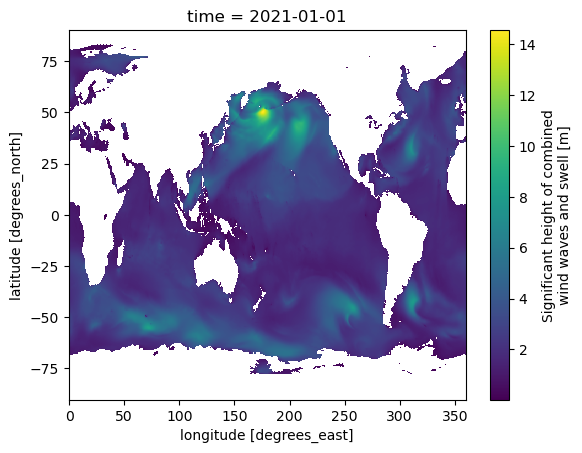

In [9]:
swh_map = SWH_model.sel(time=SWH_model['time'][0], method='nearest')
swh_map['swh'].plot()

In [10]:
swh_model_result = SWH_model.interp({
                    'longitude':xr.DataArray(bouy_swh_feature_labels['longitude'].apply(long_360_adjust), dims='unused_dim'),
                    'latitude':xr.DataArray(bouy_swh_feature_labels['latitude'], dims='unused_dim'),
                    'time':xr.DataArray(bouy_swh_feature_labels['time'].apply(np.datetime64), dims='unused_dim')},
                    method='linear')
swh_model_result

<xarray.Dataset>
Dimensions:     (unused_dim: 446922)
Coordinates:
    longitude   (unused_dim) float64 335.2 335.2 335.2 ... 151.5 151.5 151.5
    latitude    (unused_dim) float64 65.7 65.7 65.69 65.69 ... -23.9 -23.9 -23.9
    time        (unused_dim) datetime64[ns] 2021-01-03T08:22:55.528182528 ......
  * unused_dim  (unused_dim) int64 0 1 2 3 4 ... 878389 878390 878391 878392
Data variables:
    swh         (unused_dim) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-21 12:23:29 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
bouy_swh_feature_labels['swh_model_value'] = swh_model_result['swh'].values
nan_filter = bouy_swh_feature_labels['swh_model_value'].isna()
bouy_swh_feature_labels_nan_model = bouy_swh_feature_labels[nan_filter]
bouy_swh_feature_labels = bouy_swh_feature_labels[~nan_filter]
bouy_swh_feature_labels

/tmp/ipykernel_11022/1151688794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bouy_swh_feature_labels['swh_model_value'] = swh_model_result['swh'].values


,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split,swh_model_value
162,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,AR_TS_MO_Grindavikurdufl,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,HH,31.000498,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,EW,SENTINEL-1A,Descending,GRDH,...,-22.460501,63.813332,2021-01-05 08:01:59,1.959981,model,-22.460501,63.813332,2021-01-05 08:07:00.000,train,1.962094
163,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,AR_TS_MO_Grindavikurdufl,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,HV,31.000498,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,EW,SENTINEL-1A,Descending,GRDH,...,-22.460501,63.813332,2021-01-05 08:01:59,1.959981,model,-22.460501,63.813332,2021-01-05 08:07:00.000,train,1.962094
164,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,AR_TS_MO_Grindavikurdufl,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,HH,31.000410,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,EW,SENTINEL-1A,Descending,GRDH,...,-22.460501,63.813332,2021-01-05 08:01:59,1.959981,model,-22.460501,63.813332,2021-01-05 08:07:00.000,train,1.956160
165,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,AR_TS_MO_Grindavikurdufl,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,HV,31.000410,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,EW,SENTINEL-1A,Descending,GRDH,...,-22.460501,63.813332,2021-01-05 08:01:59,1.959981,model,-22.460501,63.813332,2021-01-05 08:07:00.000,train,1.956160
166,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,AR_TS_MO_Grindavikurdufl,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,HH,30.965879,S1A_EW_GRDH_1SDH_20210105T080645_20210105T0807...,EW,SENTINEL-1A,Descending,GRDH,...,-22.460501,63.813332,2021-01-05 08:01:59,1.959981,model,-22.460501,63.813332,2021-01-05 08:07:00.000,train,1.958849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878235,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,GL_TS_MO_6200163,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,VH,32.592720,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,IW,SENTINEL-1B,Descending,GRDH,...,-8.400000,47.500000,2021-12-23 07:00:00,7.564137,model,-8.400000,47.500000,2021-12-23 06:48:49.500,train,3.636379
878236,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,GL_TS_MO_6200163,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,VV,32.558376,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,IW,SENTINEL-1B,Descending,GRDH,...,-8.400000,47.500000,2021-12-23 07:00:00,7.564137,model,-8.400000,47.500000,2021-12-23 06:48:49.500,train,3.634308
878237,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,GL_TS_MO_6200163,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,VH,32.558376,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,IW,SENTINEL-1B,Descending,GRDH,...,-8.400000,47.500000,2021-12-23 07:00:00,7.564137,model,-8.400000,47.500000,2021-12-23 06:48:49.500,train,3.634308
878238,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,GL_TS_MO_6200163,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,VV,32.524334,S1B_IW_GRDH_1SDV_20211223T064837_20211223T0649...,IW,SENTINEL-1B,Descending,GRDH,...,-8.400000,47.500000,2021-12-23 07:00:00,7.564137,model,-8.400000,47.500000,2021-12-23 06:48:49.500,train,3.632633


In [12]:
bouy_swh_feature_labels_nan_model

,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split,swh_model_value
0,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train,NaN
1,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.741270,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train,NaN
2,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train,NaN
3,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HV,28.704935,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train,NaN
4,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,AR_TS_MO_Blakksnes,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,HH,28.704821,S1A_EW_GRDH_1SDH_20210103T082208_20210103T0823...,EW,SENTINEL-1A,Descending,GRDH,...,-24.778168,65.69783,2021-01-03 08:00:00,9.247744,model,-24.778168,65.69783,2021-01-03 08:22:38.000,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878388,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.299194,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train,NaN
878389,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.298813,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train,NaN
878390,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.273640,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train,NaN
878391,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,GL_TS_MO_55038,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,HH,45.247898,S1B_IW_GRDH_1SSH_20211205T083312_20211205T0833...,IW,SENTINEL-1B,Ascending,GRDH,...,151.500000,-23.90000,2021-12-05 08:30:00,6.586538,model,151.500000,-23.90000,2021-12-05 08:33:24.500,train,NaN


Wave height not interpolatable mean: 1.1884017691466864
Wave height interpolatable mean: 1.5799366861150104


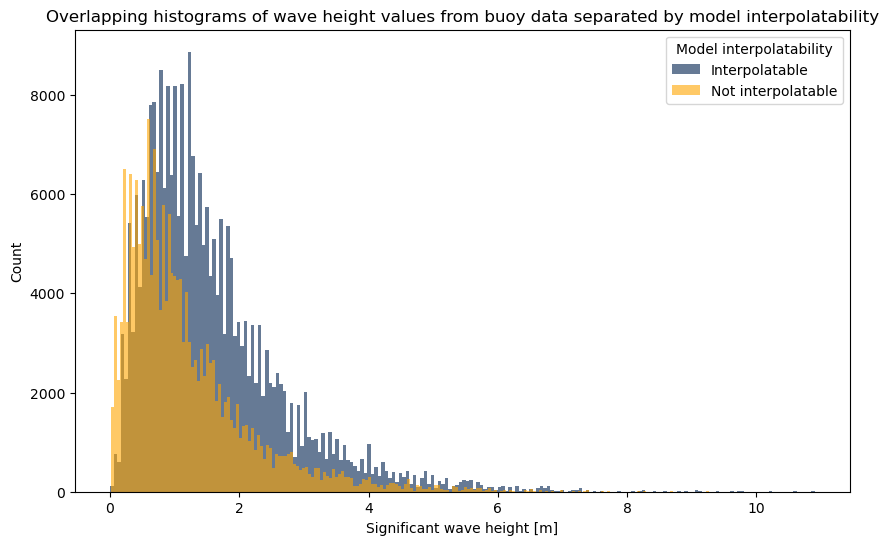

In [13]:
print(f"Wave height not interpolatable mean: {bouy_swh_feature_labels_nan_model['SWH_value'].mean()}")
print(f"Wave height interpolatable mean: {bouy_swh_feature_labels['SWH_value'].mean()}")
overlappling_hist(bouy_swh_feature_labels['SWH_value'], 'Interpolatable', bouy_swh_feature_labels_nan_model['SWH_value'], 'Not interpolatable', 'Overlapping histograms of wave height values from buoy data separated by model interpolatability', 'Significant wave height [m]', legend_title="Model interpolatability", bins=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


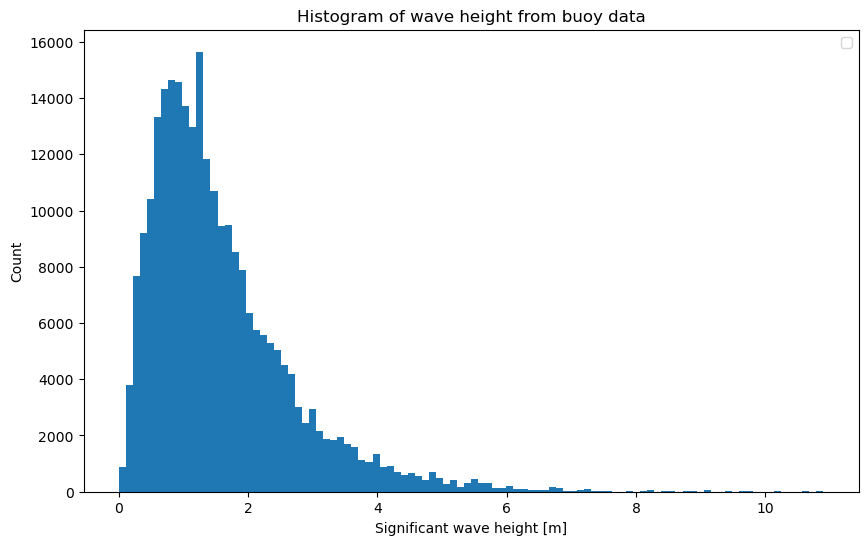

In [14]:
pm.my_histogram(bouy_swh_feature_labels['SWH_value'], "Histogram of wave height from buoy data", "Significant wave height [m]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


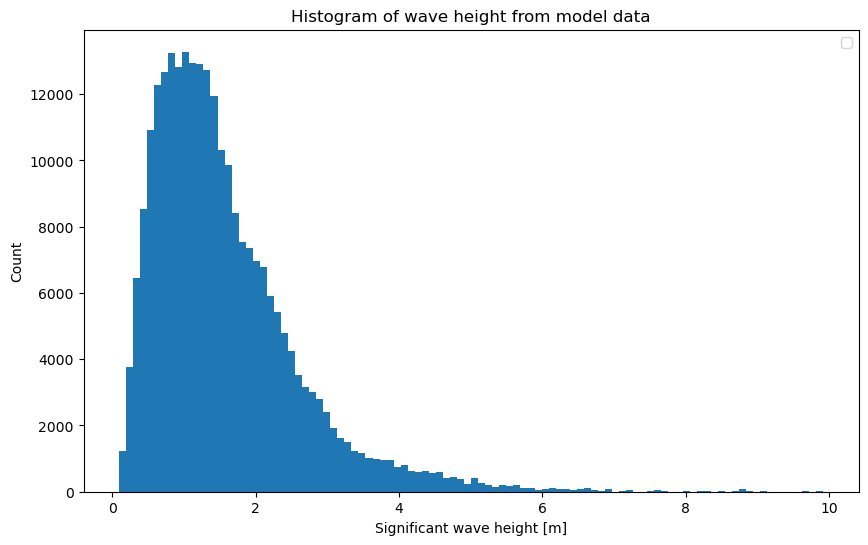

In [15]:
pm.my_histogram(bouy_swh_feature_labels['swh_model_value'], "Histogram of wave height from model data", "Significant wave height [m]")

{'RMSE': 0.3671429258540438, 'Bias': -0.013537176099822416, 'Slope': 0.8665136667832924, 'Correlation': 0.9457568354276712, 'Data points': 258792}


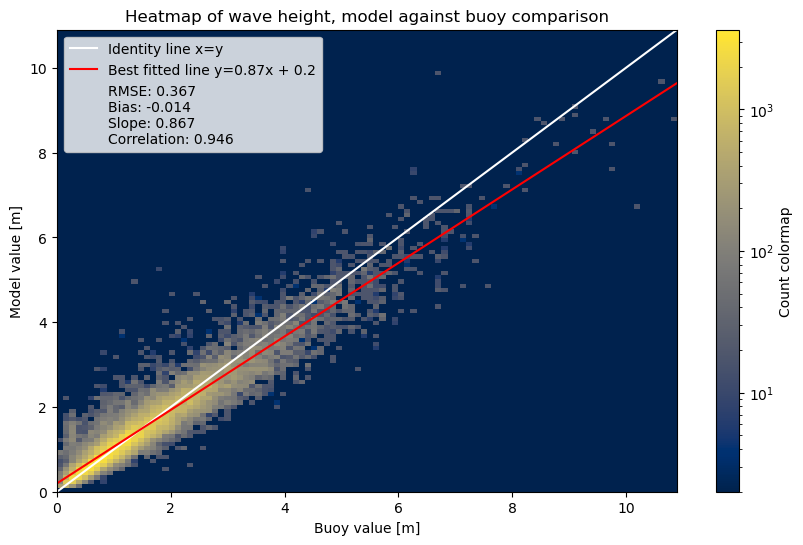

In [17]:
reload(pm)
print(pm.metrics(bouy_swh_feature_labels, "SWH_value", "swh_model_value"))
pm.heatmap(bouy_swh_feature_labels, "wave height", "wave height, model against buoy comparison", "m", "SWH_value", "swh_model_value", best_line=True, target_label_override="Buoy value [m]", prediction_label_override='Model value [m]', save_as="./figures/Model_buoy_comparison_wave.pdf")

# Compare wind speed from buoy and model

In [18]:
bouy_wspd_feature_labels = feature_labels[(feature_labels['WSPD_source'] == 'bouy')]
bouy_wspd_feature_labels

,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_source,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split
2862,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.362354,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,bouy,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train
2863,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HV,25.362354,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,bouy,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train
2864,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.362125,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,bouy,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train
2865,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HV,25.362125,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,bouy,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train
2866,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.398554,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,bouy,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878043,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VH,34.604012,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train
878044,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VV,34.571701,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train
878045,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VH,34.571701,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train
878046,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VV,34.571568,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,bouy,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train


<AxesSubplot: >

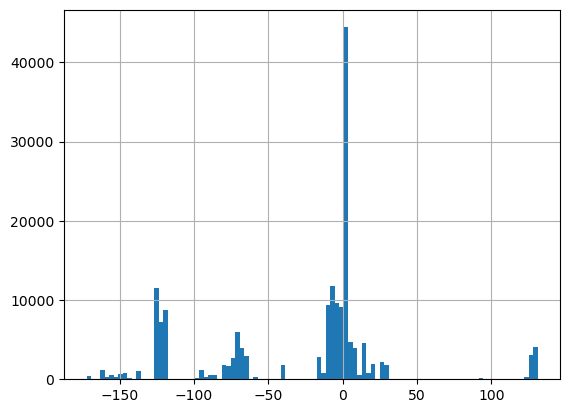

In [19]:
bouy_wspd_feature_labels['longitude'].hist(bins=100)

In [20]:
WSPD_model

<xarray.Dataset>
Dimensions:         (time: 8760, lat: 1280, lon: 2880)
Coordinates:
  * lat             (lat) float32 -79.94 -79.81 -79.69 ... 79.69 79.81 79.94
  * lon             (lon) float32 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * time            (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    eastward_wind   (time, lat, lon) float32 ...
    northward_wind  (time, lat, lon) float32 ...
Attributes: (12/31)
    title:                                           Global Ocean - Wind and ...
    summary:                                        Global ocean 10-m stress-...
    keywords:                                       ocean winds, wind speed, ...
    Conventions:                                    CF-1.6, ACDD-1.3
    project:                                        Copernicus Marine Service...
    institution:                                    Royal Netherlands Meteoro...
    ...                                             ...
    date_modified:                                  2023-01-17T02:56:07
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...
    comment:                                        
    source:                                          
    NCO:                                            4.7.2
    nco_openmp_thread_number:                       1

In [21]:
bouy_wspd_feature_labels[['time', 'longitude', 'latitude']]

,time,longitude,latitude
2862,2021-01-06T20:04:00.409177856,-39.514798,59.934296
2863,2021-01-06T20:04:00.409177856,-39.514798,59.934296
2864,2021-01-06T20:04:00.487159040,-39.517082,59.938907
2865,2021-01-06T20:04:00.487159040,-39.517082,59.938907
2866,2021-01-06T20:04:00.559141376,-39.510849,59.944181
...,...,...,...
878043,2021-12-22T17:18:58.265724928,3.726542,60.648806
878044,2021-12-22T17:18:58.115923712,3.721400,60.639000
878045,2021-12-22T17:18:58.115923712,3.721400,60.639000
878046,2021-12-22T17:18:58.190824448,3.719495,60.643449


In [22]:
def pythagoras(a, b):
    return np.sqrt(a**2 + b**2)

In [23]:
wspd_model_result = pd.Series(dtype='float64')
for i, (long, lat, time) in tqdm(bouy_wspd_feature_labels[['longitude', 'latitude', 'time']].iterrows(), total=bouy_wspd_feature_labels.shape[0]):
    WSPD_interp = WSPD_model.interp({
                        'lon':long,
                        'lat':lat,
                        'time':np.datetime64(time)},
                        method='linear')
    wspd_model_result = pd.concat([
        wspd_model_result,
        pd.Series(pythagoras(WSPD_interp['eastward_wind'].values, WSPD_interp['northward_wind'].values))])
wspd_model_result

100%|██████████| 172752/172752 [39:43<00:00, 72.49it/s] 


0    5.860822
0    5.860822
0    5.883218
0    5.883218
0    5.901570
       ...   
0    8.920262
0    8.969870
0    8.969870
0    8.932451
0    8.932451
Length: 172752, dtype: float64

In [24]:
bouy_wspd_feature_labels['wspd_model_value'] = wspd_model_result.values
bouy_wspd_feature_labels = bouy_wspd_feature_labels[~bouy_wspd_feature_labels['wspd_model_value'].isna()]
bouy_wspd_feature_labels

/tmp/ipykernel_11022/339074488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bouy_wspd_feature_labels['wspd_model_value'] = wspd_model_result.values


,sar_name,bouy_name,file_name,pol,incidence,safe,swath,platform,orbit_pass,product,...,SWH_lon,SWH_lat,SWH_time,WSPD_value,WSPD_source,WSPD_lon,WSPD_lat,WSPD_time,split,wspd_model_value
2862,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.362354,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train,5.860822
2863,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HV,25.362354,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train,5.860822
2864,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.362125,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train,5.883218
2865,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HV,25.362125,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train,5.883218
2866,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,GL_TS_MO_44078,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,HH,25.398554,S1A_EW_GRDM_1SDH_20210106T200345_20210106T2004...,EW,SENTINEL-1A,Ascending,GRDM,...,-39.5200,59.939999,2021-01-06 20:20:00,5.530617,bouy,-39.5200,59.939999,2021-01-06 20:00:00,train,5.901570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878043,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VH,34.604012,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train,8.920262
878044,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VV,34.571701,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train,8.969870
878045,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VH,34.571701,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train,8.969870
878046,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,NO_TS_MO_Troll-A,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,VV,34.571568,S1B_IW_GRDH_1SDV_20211222T171849_20211222T1719...,IW,SENTINEL-1B,Ascending,GRDH,...,3.7193,60.643501,2021-12-22 17:20:00,1.400000,bouy,3.7193,60.643501,2021-12-22 17:20:00,train,8.932451


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


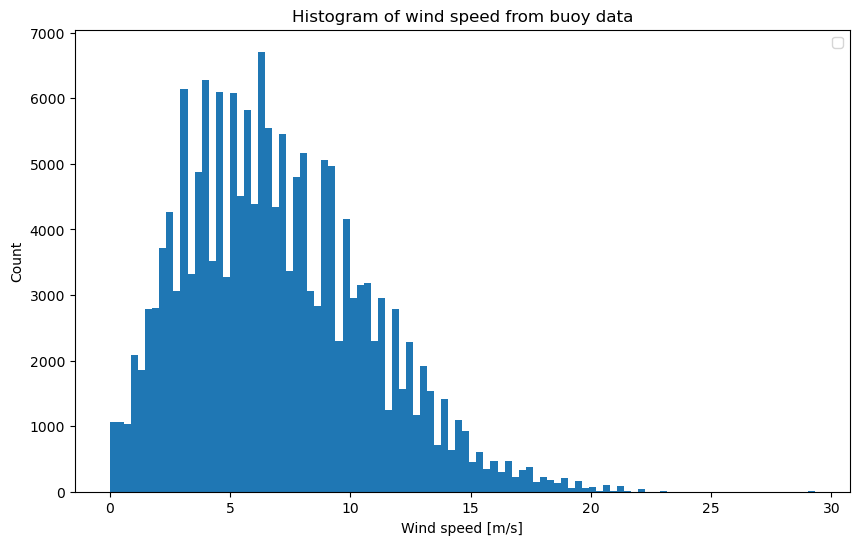

In [25]:
pm.my_histogram(bouy_wspd_feature_labels['WSPD_value'], "Histogram of wind speed from buoy data", "Wind speed [m/s]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


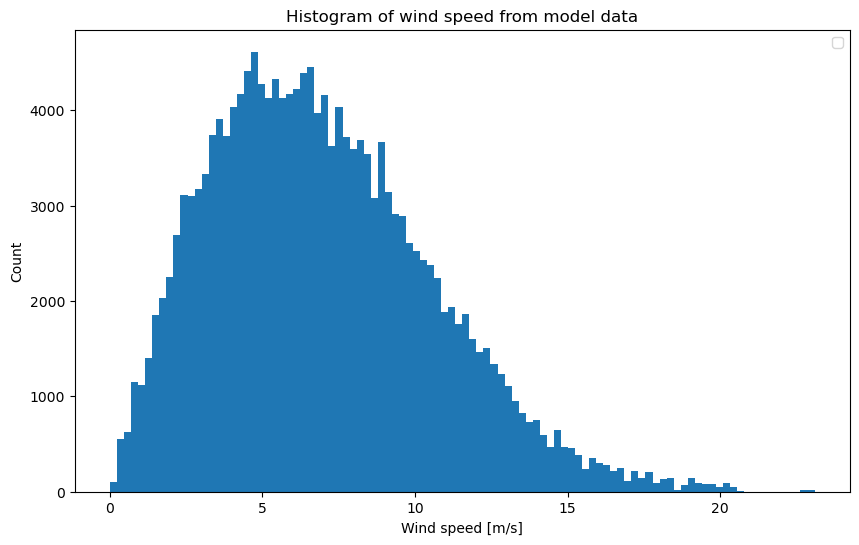

In [26]:
pm.my_histogram(bouy_wspd_feature_labels['wspd_model_value'], "Histogram of wind speed from model data", "Wind speed [m/s]")

{'RMSE': 1.8615076923131968, 'Bias': -0.03489489687911955, 'Slope': 0.830820320288085, 'Correlation': 0.875437938643719, 'Data points': 172752}


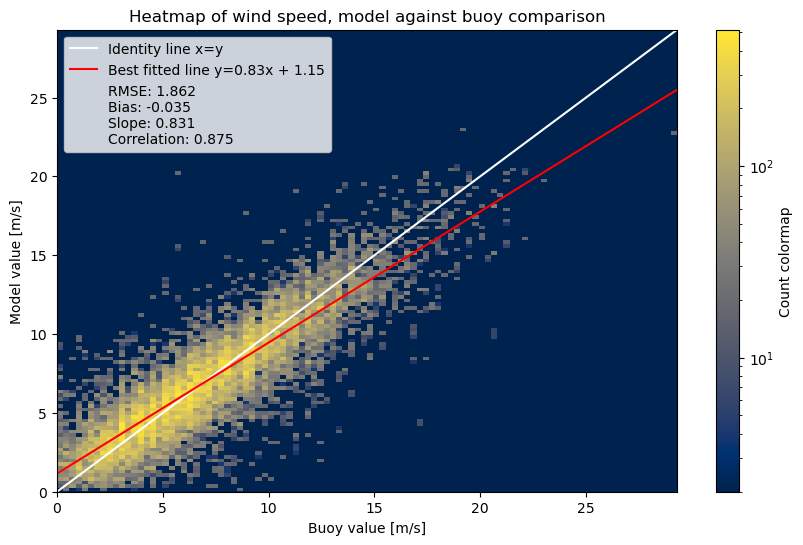

In [27]:
reload(pm)
print(pm.metrics(bouy_wspd_feature_labels, "WSPD_value", "wspd_model_value"))
pm.heatmap(bouy_wspd_feature_labels, "wind speed", "wind speed, model against buoy comparison", "m/s", "WSPD_value", "wspd_model_value", best_line=True, target_label_override="Buoy value [m/s]", prediction_label_override='Model value [m/s]', save_as="./figures/Model_buoy_comparison_wind.pdf")